## Πρόγνωση Διοξειδίου του Αζώτου (NO2) κατά μία εβδομάδα, OLSR vs SARIMAX models

In [69]:
import pandas as pd
import numpy as np
from statsmodels.regression import linear_model
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, r2_score, mean_squared_error
plt.style.use('seaborn-poster')

In [70]:
df_raw = pd.read_csv('kunak_filled.csv', parse_dates=[0], index_col=0)
df=df_raw.asfreq('H')
df.tail()

,Dew Point (C),H2S (ppb),NO2 (ppb),Humidity (%),O3 (ppb),PM1 (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3),Temp (C)
Datetime,,,,,,,,,
2022-09-04 19:00:00,20.87,25.62,64.94,34.10,41.54,11.51,12.65,15.85,28.09
2022-09-04 20:00:00,20.86,23.35,68.57,30.23,42.27,12.30,13.43,16.74,27.15
2022-09-04 21:00:00,20.92,17.31,71.04,25.90,42.23,12.83,13.93,17.00,26.60
2022-09-04 22:00:00,21.00,12.59,72.10,22.36,39.23,12.68,13.68,16.48,26.44
2022-09-04 23:00:00,21.65,18.57,79.41,25.57,42.37,12.88,14.02,18.21,25.55


In [71]:
target = 'PM2.5 (ug/m3)'
target_name = 'PM2.5' if target=='PM2.5 (ug/m3)' else target
steps = int(df.shape[0]*0.25)

train = df[:-steps]
test = df[-steps:]

drop_list = [target, 'Humidity (%)', 'H2S (ppb)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'PM1 (ug/m3)'] # , 'Dew Point (C)','PM1 (ug/m3)', 'PM2.5 (ug/m3)','PM10 (ug/m3)', 'Temp (C)', 'Humidity (%)', 'H2S (ppb)', 'NO2 (ppb)'
train_y, train_X = train[target], train.drop(columns=drop_list)
test_y, test_X = test[target], test.drop(columns=drop_list)

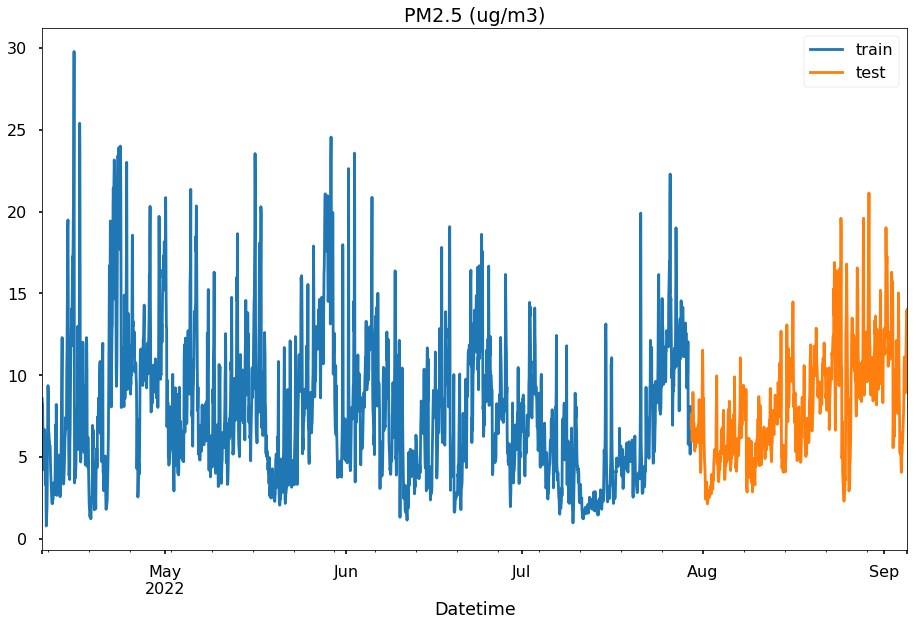

In [72]:
train[target].plot(label='train')
test[target].plot(label='test')
plt.legend()
plt.title(target)
plt.tight_layout()
plt.savefig("Plots/sarimax/train_test.png")
plt.show()

### Παλινδρόμιση Ελαχίστων Τετραγώνων

In [73]:
olsr_results = linear_model.OLS(train_y, train_X).fit()
print(olsr_results.summary())

                                 OLS Regression Results                                
Dep. Variable:          PM2.5 (ug/m3)   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.825
Method:                 Least Squares   F-statistic:                              3134.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):                        0.00
Time:                        10:11:33   Log-Likelihood:                         -7300.3
No. Observations:                2664   AIC:                                  1.461e+04
Df Residuals:                    2660   BIC:                                  1.463e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [74]:
prediction_steps = 24*7
olsr_predicted = olsr_results.get_prediction(exog=test_X)

In [75]:
predicted_values_olsr = olsr_predicted.summary_frame()['mean'][:prediction_steps]
actual = test_y[:prediction_steps]

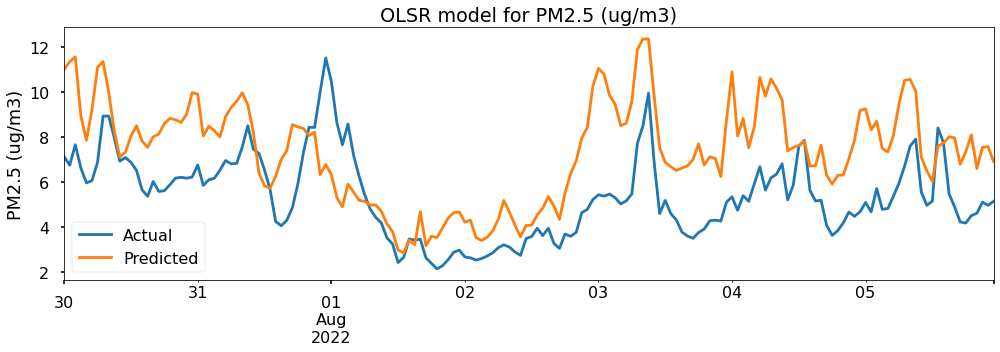

In [76]:
plt.figure(figsize=(14,5))

actual.plot(label='Actual')
predicted_values_olsr.plot(label='Predicted')
plt.title(f'OLSR model for {target}')
plt.legend(loc=3)
plt.ylabel(f'{target}')
plt.xlabel("")
plt.tight_layout()
plt.savefig(f"Plots/sarimax/{target_name}_olsr.png")
plt.show()

Αναμενόμενη αστοχία λόγω αυτοσυσχέτισης της χρονοσειράς.

### Προσδιορισμός παραμέτρων trend, seasonality, moving-average για το μοντέλο SARIMAX

In [77]:
olsr_resid_diff_1 = olsr_results.resid.diff()
olsr_resid_diff_1.dropna(inplace=True)

In [78]:
olsr_resid_diff_1_24 = olsr_resid_diff_1.diff(periods=24)
olsr_resid_diff_1_24.dropna(inplace=True)

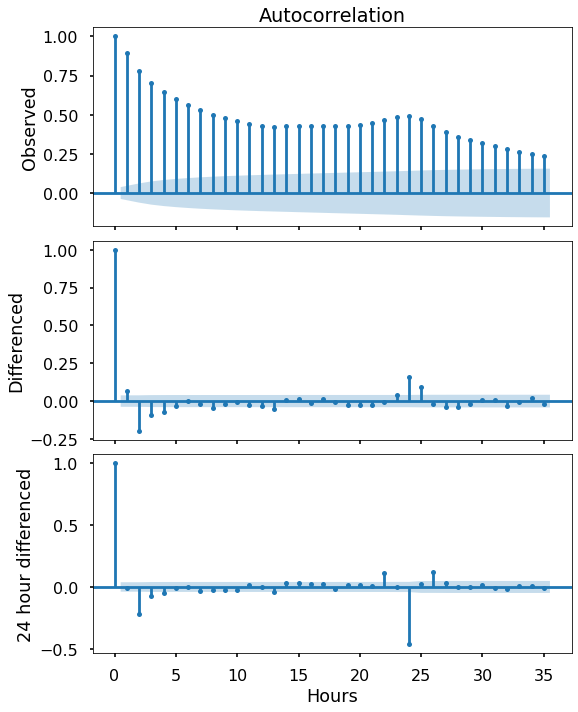

In [79]:
fig, ax = plt.subplots(3, figsize=(8,10), sharex=True)

tsa.plot_acf(olsr_results.resid, ax=ax[0])
tsa.plot_acf(olsr_resid_diff_1, ax=ax[1])
tsa.plot_acf(olsr_resid_diff_1_24, ax=ax[2])

ax[0].set_title("Autocorrelation")
ax[0].set_ylabel("Observed")
ax[1].set_title("")
ax[1].set_ylabel("Differenced")
ax[2].set_title("")
ax[2].set_ylabel("24 hour differenced")
ax[2].set_xlabel("Hours")

#plt.suptitle("Autocorrelation", fontsize=18)
plt.tight_layout()
plt.savefig("Plots/sarimax/autocorrelation.png")
plt.show()

### SARIMAX

In [80]:
p,d,q = 0,1,0

P,D,Q,m = 1,1,1,24

In [81]:
sarimax_model = ARIMA(endog=train_y, exog=train_X, order=(p,d,q), seasonal_order=(P,D,Q, m))
sarimax_results = sarimax_model.fit(method_kwargs={"warn_convergence": False})
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      PM2.5 (ug/m3)   No. Observations:                 2664
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 24)   Log Likelihood               -5050.168
Date:                            Mon, 26 Sep 2022   AIC                          10114.336
Time:                                    10:12:13   BIC                          10155.483
Sample:                                04-10-2022   HQIC                         10129.234
                                     - 07-29-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Dew Point (C)     0.3668      0.067      5.465      0.000       0.235       0.498
NO2 (ppb)         0.0905  

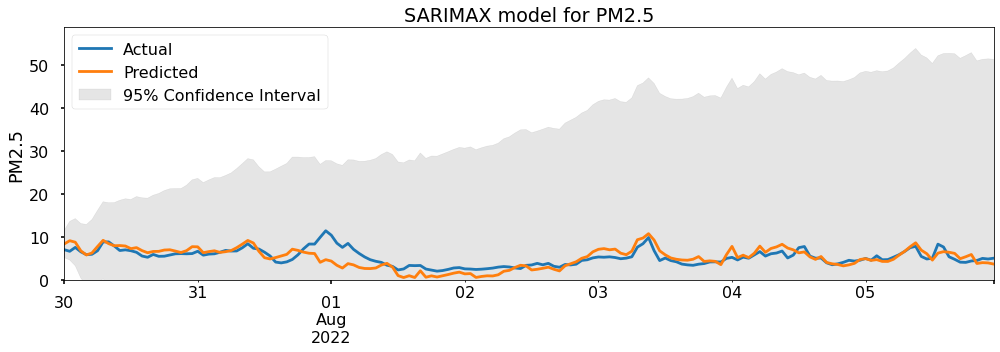

In [82]:
predictions = sarimax_results.get_forecast(prediction_steps, exog=test_X[:prediction_steps])
# predictions.summary_frame()
predicted_values_sarimax = predictions.summary_frame()['mean'][:prediction_steps]
plt.figure(figsize=(14,5))
actual.plot(label='Actual')
predicted_values_sarimax.plot(label='Predicted')
plt.fill_between(predictions.summary_frame().index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'grey', alpha = 0.2, label='95% Confidence Interval')

plt.ylim(0)
plt.legend(loc=2)
plt.title(f"SARIMAX model for {target_name}")
plt.xlabel("")
plt.ylabel(f'{target_name}')
plt.tight_layout()
plt.savefig(f"Plots/sarimax/{target_name}_sarimax.png")
plt.show()

In [83]:
errors_list = [[mean_absolute_error(predicted_values_olsr, actual), mean_absolute_error(predicted_values_sarimax, actual)],
               [mean_squared_error(predicted_values_olsr, actual), mean_squared_error(predicted_values_sarimax, actual)],
              [ mean_absolute_percentage_error(predicted_values_olsr, actual), mean_absolute_percentage_error(predicted_values_sarimax, actual)],
              [r2_score(predicted_values_olsr, actual), r2_score(predicted_values_sarimax, actual)]]

In [84]:
errors_df = pd.DataFrame(errors_list, columns=['OLSR', 'SARIMAX'], index=['MAE','MSE','MAPE','R2'])
errors_df.to_csv(f'{target_name}_regression_metrics.csv')
errors_df

,OLSR,SARIMAX
MAE,2.283682,1.205869
MSE,6.890651,2.629198
MAPE,0.303322,0.394546
R2,-0.411580,0.501524
